<a href="https://colab.research.google.com/github/cddogaru/Proyecto-de-Computacion/blob/main/Apriori%20codigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANÁLISIS DEL ESTADO Y EVOLUCIÓN DE LOS EMBALSES DE AGUA NACIONALES**


# Pasos que se seguirán para preparar los datos para el modelo Apriori
1. Instalación de librerías e importación de bibliotecas.
2. Buscamos coincidencias y filtramos por fecha.
3. Categorización y calculo del volumen.
4. Generación de transacciones y agrupación.
5. Visualización de los datos.

# (Desplazar a Archivos el dataset "Datos Embalses 1988-2024 con provincias.csv")



In [ ]:
# Instalar librerías necesarias
!pip install mlxtend
# Importar bibliotecas
import pandas as pd

# Rutas de los archivos CSV
ruta_precipitaciones = 'https://raw.githubusercontent.com/cddogaru/Proyecto-de-Computacion/refs/heads/main/PREC_1981_2010_Provincias.csv'
ruta_embalses = '/content/Datos Embalses 1988-2024 con provincias.csv'

# Cargar los datasets
precipitaciones = pd.read_csv(ruta_precipitaciones, sep=';')
embalses = pd.read_csv(ruta_embalses)

# Mostrar los primeros registros de cada dataset para confirmar la carga
print("Precipitaciones:")
print(precipitaciones.head())

print("\nEmbalses:")
print(embalses.head())

print(precipitaciones.columns)
print(embalses.columns)


Precipitaciones:
       Parametro periodo de referencia    region  enero  febrero  marzo  \
0  Precipitacion             1981-2010  A CORUNA  191.5    147.0  133.6   
1  Precipitacion             1981-2010  ALBACETE   32.2     35.5   35.3   
2  Precipitacion             1981-2010  ALICANTE   35.9     35.5   33.7   
3  Precipitacion             1981-2010   ALMERIA   34.7     34.9   30.7   
4  Precipitacion             1981-2010     ARABA   88.5     72.0   73.0   

   abril   mayo  junio  julio  agosto  septiembre  octubre  noviembre  \
0  139.0  117.5   62.6   45.4    49.8        92.0    200.2      209.9   
1   46.9   46.3   29.0    8.4    13.9        36.0     48.8       46.4   
2   38.7   40.8   18.9    5.7    11.4        54.6     56.0       51.2   
3   26.2   26.4   10.6    1.9     5.6        27.7     36.2       42.6   
4   88.4   77.2   49.8   36.5    38.2        50.1     79.0      104.8   

   diciembre   anual  
0      218.8  1607.3  
1       45.4   424.1  
2       38.5   420.9  
3

In [ ]:
# Normalizar nombres de provincias/regiones
embalses['PROVINCIA'] = embalses['PROVINCIA'].str.upper()

# Filtrar por años relevantes (1988-2010)
embalses['FECHA'] = pd.to_datetime(embalses['FECHA'], dayfirst=True)  # Añadir dayfirst=True
embalses = embalses[(embalses['FECHA'].dt.year >= 1988) & (embalses['FECHA'].dt.year <= 2010)]

# Confirmar las provincias comunes entre ambos datasets
provincias_comunes = set(precipitaciones['region']).intersection(embalses['PROVINCIA'])
embalses = embalses[embalses['PROVINCIA'].isin(provincias_comunes)]
precipitaciones = precipitaciones[precipitaciones['region'].isin(provincias_comunes)]

# Mostrar resumen después de la limpieza
print(f"Provincias comunes: {len(provincias_comunes)}")
print(f"Filas de embalses después de filtrar: {embalses.shape[0]}")
print(f"Filas de precipitaciones después de filtrar: {precipitaciones.shape[0]}")


Provincias comunes: 31
Filas de embalses después de filtrar: 226798
Filas de precipitaciones después de filtrar: 31


In [ ]:
# Categorizar precipitaciones
precipitaciones['categoria'] = pd.qcut(precipitaciones['anual'], q=3, labels=['bajo', 'medio', 'alto'])

# Calcular el volumen medio anual por provincia
embalses['anio'] = embalses['FECHA'].dt.year
volumen_medio = embalses.groupby(['PROVINCIA', 'anio'])['AGUA_ACTUAL'].mean().reset_index()

# Categorizar volúmenes de agua
volumen_medio['categoria'] = pd.qcut(volumen_medio['AGUA_ACTUAL'], q=3, labels=['bajo', 'medio', 'alto'])

# Mostrar datos categorizados
print("\nEjemplo de categorías en precipitaciones:")
print(precipitaciones[['region', 'anual', 'categoria']].head())

print("\nEjemplo de categorías en volúmenes:")
print(volumen_medio[['PROVINCIA', 'anio', 'AGUA_ACTUAL', 'categoria']].head())



Ejemplo de categorías en precipitaciones:
      region   anual categoria
1   ALBACETE   424.1      bajo
2   ALICANTE   420.9      bajo
5   ASTURIAS  1210.2      alto
7    BADAJOZ   525.4     medio
9  BARCELONA   649.2      alto

Ejemplo de categorías en volúmenes:
  PROVINCIA  anio  AGUA_ACTUAL categoria
0  ALBACETE  1988     7.230769      bajo
1  ALBACETE  1989    10.990385      bajo
2  ALBACETE  1990     9.865385      bajo
3  ALBACETE  1991     7.320755      bajo
4  ALBACETE  1992     7.461538      bajo


In [ ]:
# Combinar datasets asegurando los nombres correctos
datos = volumen_medio.merge(precipitaciones, left_on='PROVINCIA', right_on='region')

# Agrupar datos por provincia y combinar categorías
datos_agrupados = datos.groupby('PROVINCIA').agg({
    'categoria_x': 'first',  # Categoría de volumen
    'categoria_y': 'first',  # Categoría de precipitación
    'AGUA_ACTUAL': 'mean',   # Volumen medio de agua
    'anual': 'mean'          # Precipitación media anual
}).reset_index()

# Crear transacciones únicas por provincia
transacciones = datos_agrupados.apply(lambda row: [
    f"PRECIPITACION_{row['categoria_y']}",
    f"VOLUMEN_{row['categoria_x']}",
    f"PROVINCIA_{row['PROVINCIA']}"
], axis=1).tolist()

# Mostrar datos agrupados
print("\nEjemplo de datos agrupados:")
print(datos_agrupados.head())

# Mostrar transacciones
print("\nEjemplo de transacciones agrupadas:")
print(transacciones[:5])



Ejemplo de datos agrupados:
   PROVINCIA categoria_x categoria_y  AGUA_ACTUAL   anual
0   ALBACETE        bajo        bajo     8.424718   424.1
1   ALICANTE        bajo        bajo    24.440908   420.9
2   ASTURIAS       medio        alto    62.375410  1210.2
3    BADAJOZ        alto       medio   200.362645   525.4
4  BARCELONA        alto        alto    89.201765   649.2

Ejemplo de transacciones agrupadas:
[['PRECIPITACION_bajo', 'VOLUMEN_bajo', 'PROVINCIA_ALBACETE'], ['PRECIPITACION_bajo', 'VOLUMEN_bajo', 'PROVINCIA_ALICANTE'], ['PRECIPITACION_alto', 'VOLUMEN_medio', 'PROVINCIA_ASTURIAS'], ['PRECIPITACION_medio', 'VOLUMEN_alto', 'PROVINCIA_BADAJOZ'], ['PRECIPITACION_alto', 'VOLUMEN_alto', 'PROVINCIA_BARCELONA']]


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
!pip install --upgrade mlxtend
# Crear una nueva columna categórica basada en la precipitación anual
def categorizar_precipitacion(valor):
    if valor < 400:
        return 'Baja'
    elif 400 <= valor < 800:
        return 'Media'
    else:
        return 'Alta'

precipitaciones['PRECIPITACION_CAT'] = precipitaciones['anual'].apply(categorizar_precipitacion)

# Visualizar el resultado
print(precipitaciones[['region', 'anual', 'PRECIPITACION_CAT']].head())


      region   anual PRECIPITACION_CAT
1   ALBACETE   424.1             Media
2   ALICANTE   420.9             Media
5   ASTURIAS  1210.2              Alta
7    BADAJOZ   525.4             Media
9  BARCELONA   649.2             Media


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


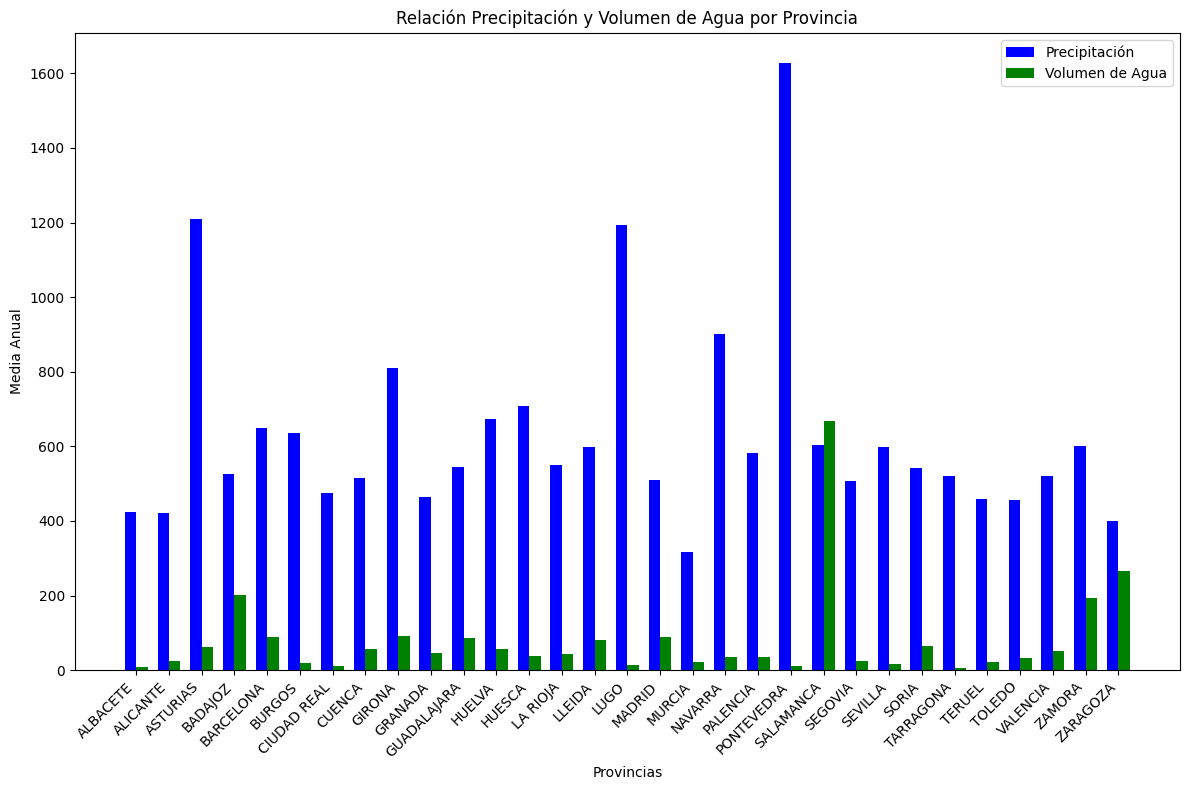

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener los datos necesarios
provincias = datos_agrupados['PROVINCIA']
precipitaciones = datos_agrupados['anual']
volumen_agua = datos_agrupados['AGUA_ACTUAL']

# Crear un índice para las provincias
x = np.arange(len(provincias))

# Ancho de las barras
bar_width = 0.35

# Crear la figura
fig, ax = plt.subplots(figsize=(12, 8))

# Barras para precipitaciones
ax.bar(x - bar_width / 2, precipitaciones, bar_width, label='Precipitación', color='blue')

# Barras para volumen de agua
ax.bar(x + bar_width / 2, volumen_agua, bar_width, label='Volumen de Agua', color='green')

# Añadir etiquetas y título
ax.set_xlabel('Provincias')
ax.set_ylabel('Media Anual')
ax.set_title('Relación Precipitación y Volumen de Agua por Provincia')
ax.set_xticks(x)
ax.set_xticklabels(provincias, rotation=45, ha='right')
ax.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

